In [1]:
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from venny4py.venny4py import *
from Bio import SeqIO, Entrez
import py3Dmol

from dotenv import load_dotenv
env_file = '/home/yuan/bio/bio_omics/src/pipelines/.env'
load_dotenv(dotenv_path = env_file)

%load_ext autoreload
%autoreload 2

src_dir = os.path.dirname(os.getcwd())
print('src direcotry is ', src_dir)
bioomics_dir = '/home/yuan/bio/bio_omics/src'
for _dir in (src_dir, bioomics_dir):
    if _dir not in sys.path:
        sys.path.append(_dir)
print(sys.path)

from bioomics import QueryComplex
from plot_venn import PlotVenn
from layout import Layout

src direcotry is  /home/yuan/bio/predict_antibody
['/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python310.zip', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/lib-dynload', '', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages', '/home/yuan/bio/predict_antibody', '/home/yuan/bio/bio_omics/src']


## Antibody labeling on PDB data

In [2]:
# detect antibody chain in PDB using blastp alignment against UniProt-Sprot references
query = """
    SELECT U.uniprot_acc, C.pdb_id, C.chain_id, C.chain_no, C.chain_seq,
        CONCAT(C.pdb_id, '_', C.chain_no) AS chain
    FROM view_pdb_chain C
    LEFT JOIN align_uniprot U ON C.chain_id = U.chain_id
    WHERE C.model_no = 0
        AND U.evalue <= 1e-10 AND U.bit_score >= 100
        AND U.uniprot_acc IN (
            SELECT uniprot_acc FROM uniprot_keyword
            WHERE keyword = 'Monoclonal antibody'
              OR keyword = 'Immunoglobulin'
        )
;"""
uniprot_df = QueryComplex(True).list_data(query, True)
print('Unique PDB structures: ', len(uniprot_df['pdb_id'].unique()))
print('Unique chain ids: ', len(uniprot_df['chain_id'].unique()))
print('Unique chains: ', len(uniprot_df['chain'].unique()))
print('Unique sequences: ', len(uniprot_df['chain_seq'].unique()))

Unique PDB structures:  9889
Unique chain ids:  31878
Unique chains:  31878
Unique sequences:  16477


In [3]:
uniprot_df.head()

,uniprot_acc,pdb_id,chain_id,chain_no,chain_seq,chain
0,P0DOX7,3IJH,3IJH_0_A_0,A,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,3IJH_A
1,P84751,3IJH,3IJH_0_B_0,B,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,3IJH_B
2,P0DOX7,3IJH,3IJH_0_C_0,C,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,3IJH_C
3,P84751,3IJH,3IJH_0_D_0,D,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,3IJH_D
4,P0DOX7,9IJS,9IJS_0_H_0,H,VQLVESGGGLVQPGGSLRLSCAASGFNVYSSSIHWVRQAPGKGLEW...,9IJS_H


In [4]:
# detect antibody chain in PDB using igblastp alignment against IMGT V-regions
query = """
    SELECT I.allele_name, C.pdb_id, C.chain_id, C.chain_no, C.chain_seq, I.chain_type,
        CONCAT(C.pdb_id, '_', C.chain_no) AS chain
    FROM view_pdb_chain C
    LEFT JOIN align_vregion I ON C.chain_id = I.chain_id
    WHERE C.model_no = 0
        AND I.evalue <= 1e-10 AND I.bit_score >= 100 AND I.isotype = 'IG'
;"""
imgt_df = QueryComplex(True).list_data(query, True)
print('Unique PDB structures: ', len(imgt_df['pdb_id'].unique()))
print('Unique chain_ids: ', len(imgt_df['chain_id'].unique()))
print('Unique chains: ', len(uniprot_df['chain'].unique()))
print('Unique sequences: ', len(imgt_df['chain_seq'].unique()))

Unique PDB structures:  9655
Unique chain_ids:  31086
Unique chains:  31878
Unique sequences:  16083


In [5]:
imgt_df.head()

,allele_name,pdb_id,chain_id,chain_no,chain_seq,chain_type,chain
0,IGKV8-21*01,3IJH,3IJH_0_A_0,A,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,K,3IJH_A
1,IGHV7-3*02,3IJH,3IJH_0_B_0,B,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,H,3IJH_B
2,IGKV8-21*01,3IJH,3IJH_0_C_0,C,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,K,3IJH_C
3,IGHV7-3*02,3IJH,3IJH_0_D_0,D,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,H,3IJH_D
4,IGKV1-21*01,9IJS,9IJS_0_H_0,H,VQLVESGGGLVQPGGSLRLSCAASGFNVYSSSIHWVRQAPGKGLEW...,K,9IJS_H


In [6]:
# detect antibody chain in PDB according PDB annotations submitted by authors
query = """
    SELECT pdb_id, chains FROM pdb_compound
    WHERE compound_text REGEXP 'antibody|nanobody|immunoglobulin'
        AND compound_text NOT LIKE "%TCR%"
;"""
compound_df = QueryComplex(True).list_data(query, True)
compound_df['chain_no'] = compound_df['chains'].str.upper().str.split(',')
compound_df = compound_df.explode('chain_no')
compound_df['chain'] = compound_df.apply(lambda x: x['pdb_id'] + '_' + x['chain_no'], axis=1)
compound_df.head(10)

,pdb_id,chains,chain_no,chain
0,1A14,h,H,1A14_H
1,1A14,l,L,1A14_L
2,1A3L,l,L,1A3L_L
3,1A3L,h,H,1A3L_H
4,1A3R,l,L,1A3R_L
5,1A3R,h,H,1A3R_H
6,1A4J,"l,a",L,1A4J_L
6,1A4J,"l,a",A,1A4J_A
7,1A4J,"h,b",H,1A4J_H
7,1A4J,"h,b",B,1A4J_B


figure size: 11.4 x 8 cm


/home/yuan/bio/predict_antibody/src/plot_venn.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


<Axes: >

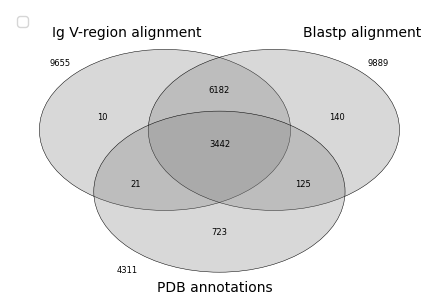

In [7]:
args = {'width_level': 2, 'height': 8}
fig, ax = Layout(args).one()
pdb_sets = {
    'Ig V-region alignment': set(imgt_df['pdb_id']),
    'Blastp alignment': set(uniprot_df['pdb_id']),
    'PDB annotations': set(compound_df['pdb_id']),
}
labels_xy = [(10,90), (70,90), (35,-5)]
PlotVenn.venn_chain(pdb_sets, ax, labels_xy)

figure size: 11.4 x 8 cm


<Axes: >

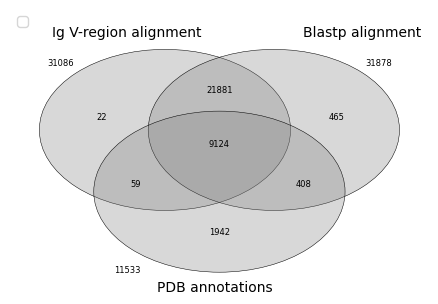

In [8]:
args = {'width_level': 2, 'height': 8}
fig, ax = Layout(args).one()
chain_sets = {
    'Ig V-region alignment': set(imgt_df['chain']),
    'Blastp alignment': set(uniprot_df['chain']),
    'PDB annotations': set(compound_df['chain']),
}
labels_xy = [(10,90), (70,90), (35,-5)]
PlotVenn.venn_chain(chain_sets, ax, labels_xy)

## antibody databases

In [9]:
query = "select pdb_id from ab_aacdb;"
aacdb_df = QueryComplex().list_data(query, True)
aacdb_df.head(1)

,pdb_id
0,1A14


In [10]:
query = "select pdb_id from ab_abybank;"
abybank_df = QueryComplex().list_data(query, True)
abybank_df.head(1)

,pdb_id
0,1BLN


In [11]:
query = "select pdb_id, heavy_chain, light_chain from ab_sabdab;"
sabdab_df = QueryComplex().list_data(query, True)
sabdab_df1 = sabdab_df[['pdb_id', 'heavy_chain']].dropna()
sabdab_df1['chain_type'] = 'heavy'
sabdab_df2 = sabdab_df[['pdb_id', 'light_chain']].dropna()
sabdab_df2['chain_type'] = 'light'
sabdab_df = np.vstack([sabdab_df1, sabdab_df2])
sabdab_df = pd.DataFrame(sabdab_df, columns=['pdb_id', 'chain_no', 'chain_type'])
sabdab_df['chain'] = sabdab_df.apply(lambda x: x['pdb_id'] + '_' + x['chain_no'], axis=1)
sabdab_df.head()

,pdb_id,chain_no,chain_type,chain
0,7C2E,N,heavy,7C2E_N
1,1MHP,H,heavy,1MHP_H
2,1MHP,X,heavy,1MHP_X
3,1U8Q,B,heavy,1U8Q_B
4,7ME7,A,heavy,7ME7_A


figure size: 11.4 x 8 cm


/home/yuan/bio/predict_antibody/src/plot_venn.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


<Axes: >

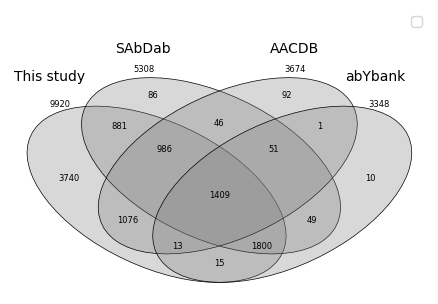

In [12]:
args = {'width_level': 2, 'height': 8}
fig, ax = Layout(args).one()
pdb_sets = {
    'This study': set(imgt_df['pdb_id']).union(uniprot_df['pdb_id']),
    'SAbDab': set(sabdab_df['pdb_id']),
    'AACDB': set(aacdb_df['pdb_id']),
    'abYbank': set(abybank_df['pdb_id']),
}
labels_xy = [(1,75), (25,85), (62,85), (80,75)]
PlotVenn.venn_chain(pdb_sets, ax, labels_xy)

## figures

figure size: 11.4 x 8 cm


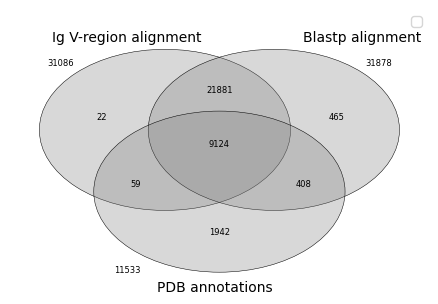

In [13]:
args = {'width_level': 2, 'height': 8}
fig, ax = Layout(args).one()

chain_sets = {
    'Ig V-region alignment': set(imgt_df['chain']),
    'Blastp alignment': set(uniprot_df['chain']),
    'PDB annotations': set(compound_df['chain']),
}
labels_xy = [(10,88), (70,88), (35,-5)]
PlotVenn.venn_chain(chain_sets, ax, labels_xy)

fig.savefig('../figures/venn_detect_antibody.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

In [14]:
pdb_sets = {
    'This study': set(imgt_df['pdb_id']).union(uniprot_df['pdb_id']),
    'SAbDab': set(sabdab_df['pdb_id']),
    'AACDB': set(aacdb_df['pdb_id']),
    'abYbank': set(abybank_df['pdb_id']),
}

imgt_heavy = imgt_df[imgt_df['chain_type']=='H']
sabdab_heavy = sabdab_df[sabdab_df['chain_type']=='heavy']
heavy_sets = {
    'This study': set(imgt_heavy['chain']),
    'SAbDab': set(sabdab_heavy['chain']),
}

imgt_light = imgt_df[imgt_df['chain_type'].isin(['L','K'])]
sabdab_light = sabdab_df[sabdab_df['chain_type']=='light']
light_sets = {
    'This study': set(imgt_light['chain']),
    'SAbDab': set(sabdab_light['chain']),
}

figure size: 17.4 x 8 cm


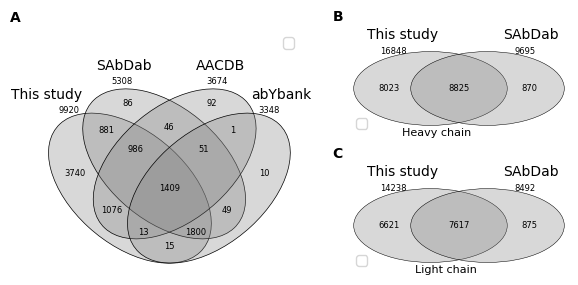

In [18]:
args = {'width_level': 3, 'height': 8, 'wspace':.2, 'hspace':.3, 'width_ratios': [1.2,1]}
label_xytext = [(-20,14), (-12,15), (-12,15)]
fig, axes = Layout(args).col1_col2(label_xytext)

labels_xy = [(-10,72), (22,84), (60,84), (81,72)]
PlotVenn.venn_chain(pdb_sets, axes[0], labels_xy)

labels_xy = [(8,92), (70,92),]
PlotVenn.venn_chain(heavy_sets, axes[1], labels_xy)
axes[1].text(24, 0, 'Heavy chain', fontsize=8)
PlotVenn.venn_chain(light_sets, axes[2], labels_xy)
axes[2].text(30, 0, 'Light chain', fontsize=8)

fig.savefig('../figures/venn_compare_database.tif', dpi=300, bbox_inches='tight', pad_inches=.05)